(DATA 5000 Project) IBM Telco Customer Churn Dataset EDA Report

This part of our project focuses on **exploring and understanding the Telco Customer Churn dataset** before any modeling takes place.

The goal of this notebook is to:
- Understand the structure and content of the dataset
- Identify patterns, trends, and relationships between features and churn
- Spot any data quality issues (e.g., missing values, outliers, class imbalance)
- Decide what preprocessing steps may be needed later (e.g., scaling, encoding, SMOTE)

No machine learning models are built here. This is only about building a good foundation for the modeling notebook that comes next.


In [11]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2

# We start by loading the Telco Customer Churn dataset into a DataFrame:
data = pd.read_csv('c:\datasets\churn.csv')

# To safely explore and modify the dataset if needed, we'll make a deep copy of the original data:
df_temp= data.copy(deep = True)

data.head()  # print a few rows of dataset

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


DATA CLEANING

In [12]:
# Obtain Dataset dimensions & variable types

print("Dimensions:", data.shape, "\n")
print("Variable types:")
print(data.info())  # this function tells us if there are any missing values

# At a glance, it looks like there are no missing values, but we’ll confirm this more thoroughly

Dimensions: (7043, 21) 

Variable types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  P

In [13]:
#'TotalCharges' is actually a numerical attriibute (it shows a total amount), but was read as an object
#(likely because of presence of strings or spaces).  

# To fix this we'll convert it to numerical and check dataset for missing values again

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# errors='coerce' means: if a value can’t be converted to a number, it will be replaced with NaN 
# (missing value)

# Check for any missing values again after conversion
data.isnull().sum()

# There are 11 missing values in the TotalCharges column

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [14]:

# The SeniorCitizen column is currently encoded as 0 and 1.
# for easier reading and analysis, we’ll convert these numbers into clear labels:


# Create mapping
senior_map = {0: 'No', 1: 'Yes'}

# Use the map() function to replace the categories
data['SeniorCitizen'] = data['SeniorCitizen'].map(senior_map)


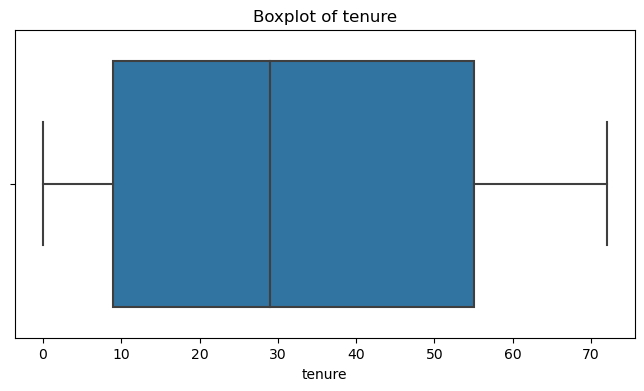

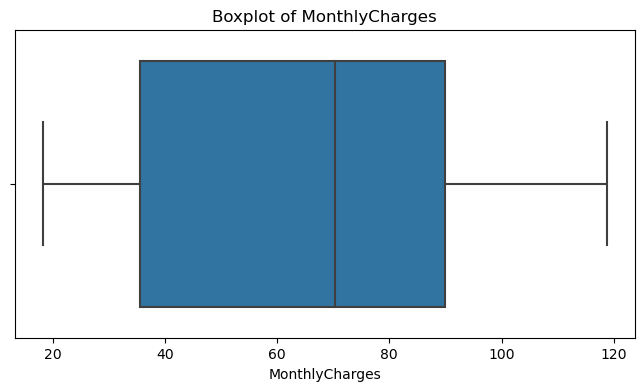

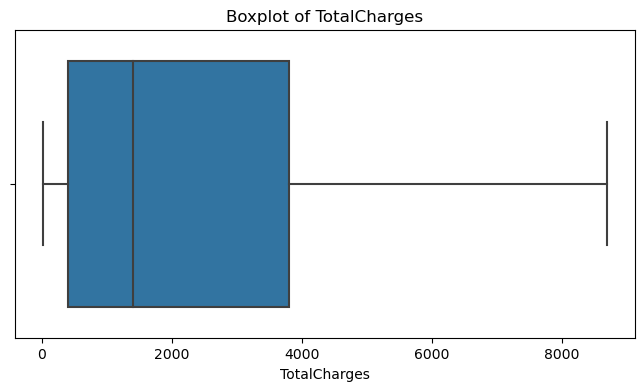

In [15]:
# Check numeric variables for outliers:  shows no outliers

# Outliers are extreme values that are unusually high or low compared
# to the rest of the data. These can sometimes distort a models
# learning process, especially for algorithms that are sensitive to scale.

# We’ll use boxplots to visually inspect the numeric columns:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create a boxplot for each numerical column
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=col, data=data)
    plt.title(f'Boxplot of {col}')
    plt.show()

EXPLORATION / VISUALIZATION 

Axes(0.125,0.11;0.775x0.77)


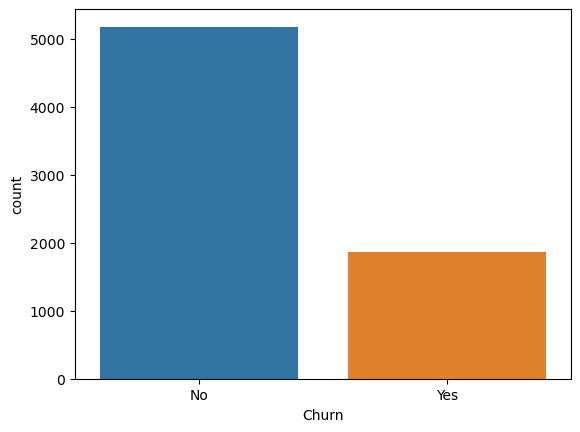

In [16]:
# Visualize distribution of class variable 

# Before building models, it's important to understand the distribution of the
# target variable — in this case, whether or not a customer has churned. 

# We’ll use a simple count plot to see how many customers fall into each category:

churn_dist=sns.countplot(x='Churn', data=data)
print(churn_dist)

# We can see that about 27% of customers have churned.

# ** IMPORTANT: **
# The dataset is imbalanced: meaning one class (No churn) appears much more often
# than the other (Yes churn). We will to have look at resampling techniques like SMOTE.

<Axes: >

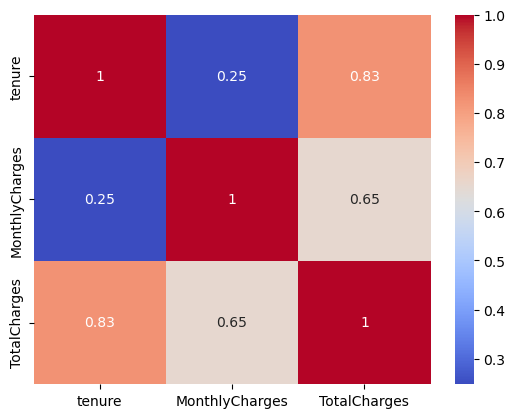

In [17]:
#Examine correlation between the numeric features

# This is necessary to detect redundant variables.
# When two variables are highly correlated, they may be redundant
# (e.g., two variables that are very similar)

# Select numeric columns
numeric_cols = data.select_dtypes(include=[np.number])

# Calculate correlation
corr = numeric_cols.corr()

# Plot and print a heatmap
corr_heatmap=sns.heatmap(corr, annot=True, cmap='coolwarm')
corr_heatmap

#  monthlycharges and totalcharges, which have a high positive association of 0.65.
# Customers with higher monthly charges tend to have higher total charges-- which makes sense.

# It is no surprise that tenure and TotalCharges have a high correlation. The longer
# a customer has been around, the the higher TotalCharges should be.
# Note: Correlation is not causation

In [18]:
# Print summary statistics for all columns

data.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7032.000000,7043
unique,7043,2,2,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,NaN,2
top,7590-VHVEG,Male,No,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,3555,5901,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,5174
mean,NaN,NaN,NaN,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2283.300441,NaN
std,NaN,NaN,NaN,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.771362,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN
25%,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,401.450000,NaN
50%,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000,NaN
75%,NaN,NaN,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3794.737500,NaN


UNIVARIATE ANALYSIS

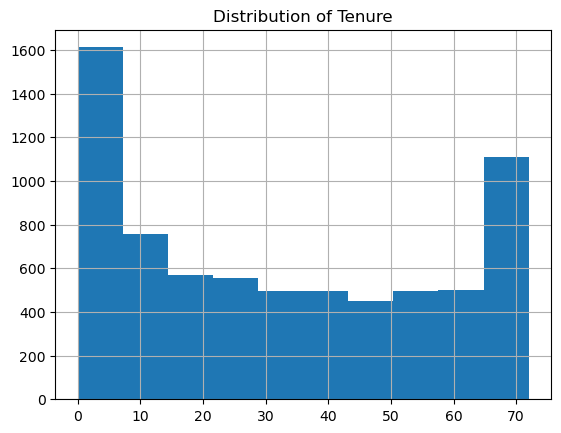

In [19]:
# Distributions of Numerical Variables

data['tenure'].hist()
plt.title('Distribution of Tenure')
plt.show()

# Bimodal: Many customers have been with company for a few months, and also many
# in the ~70 months range

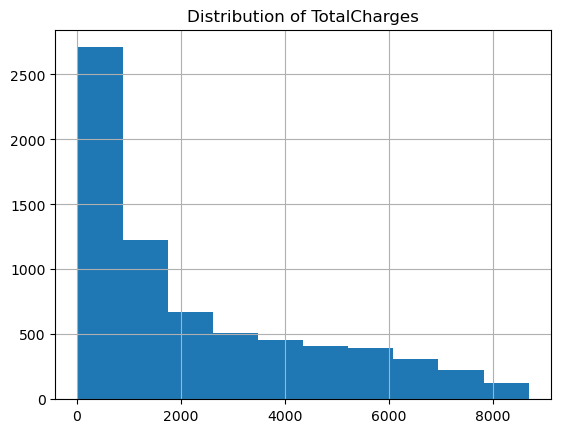

In [20]:
data['TotalCharges'].hist()
plt.title('Distribution of TotalCharges')
plt.show()

# Skewed to right. Most customer pay less than average total. Since many customers are new, it may explain peak
# showing many customers having low totalcharges

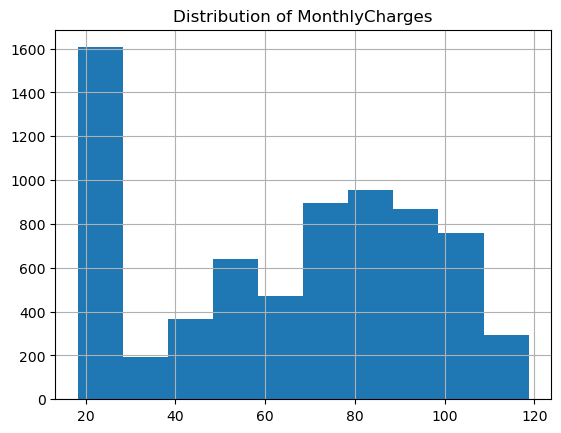

In [21]:
data['MonthlyCharges'].hist()
plt.title('Distribution of MonthlyCharges')
plt.show()

# Most customers pay lower monthly charges, with a large number clustered around $20.

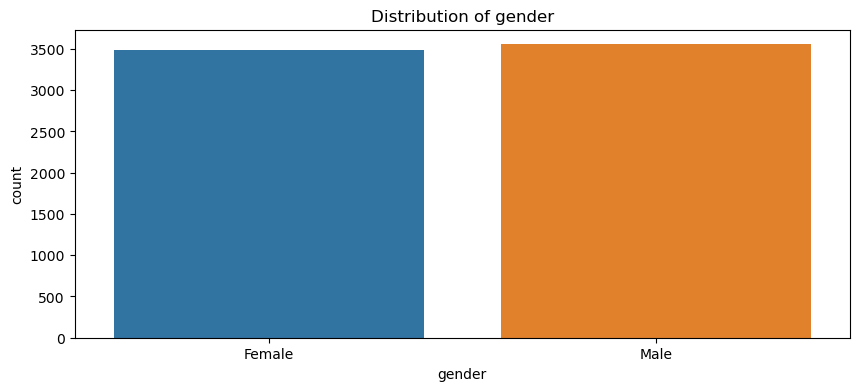

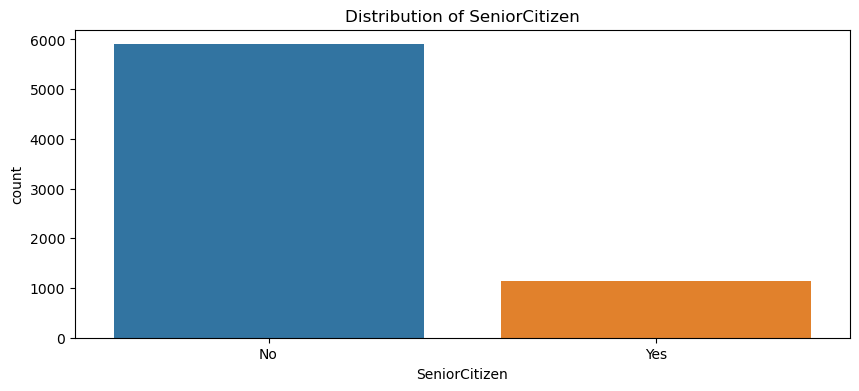

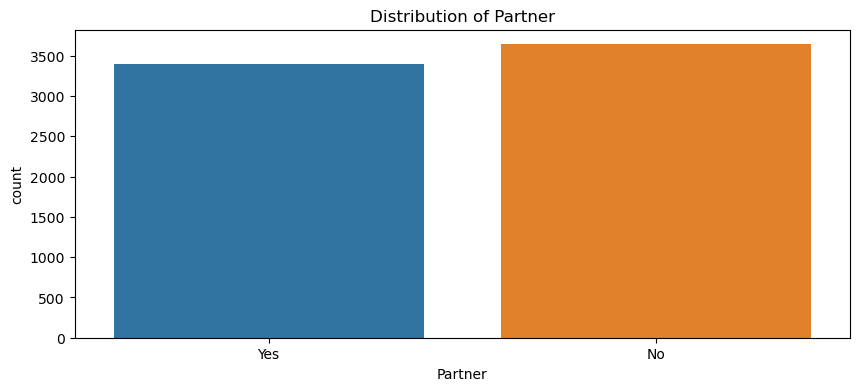

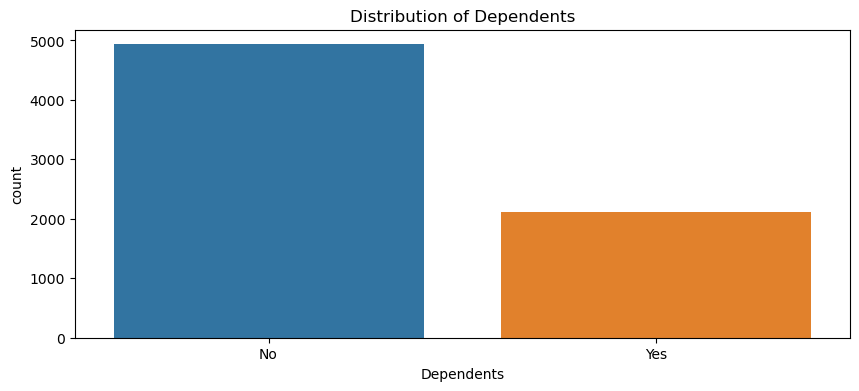

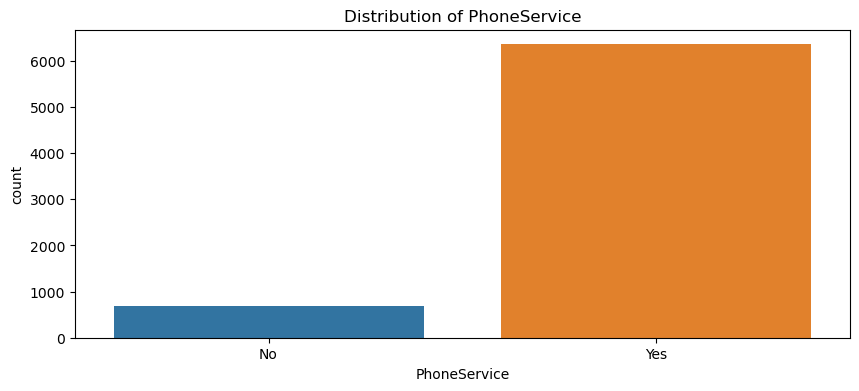

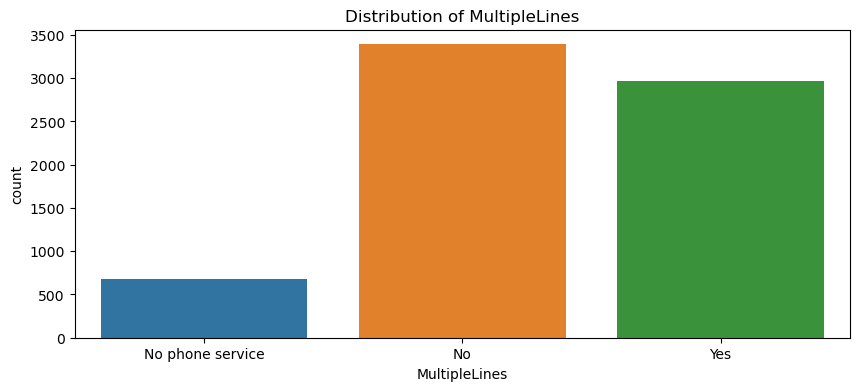

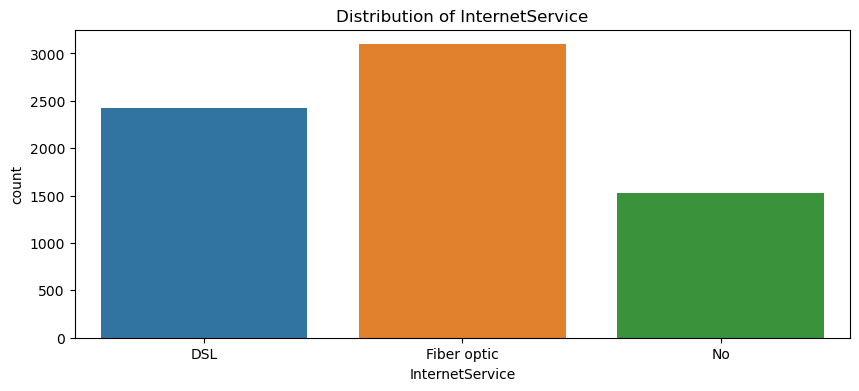

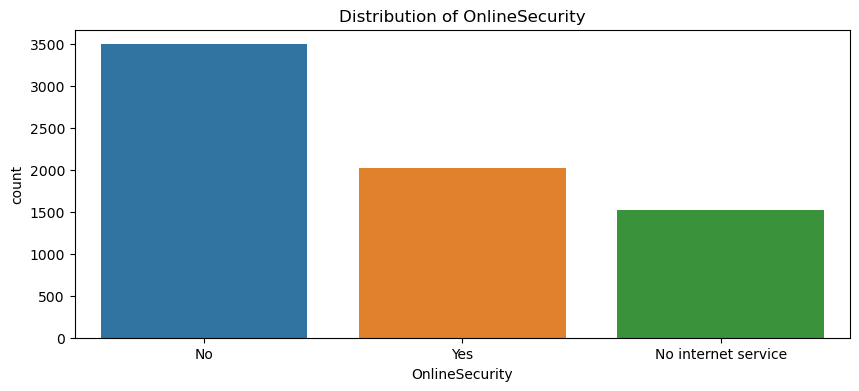

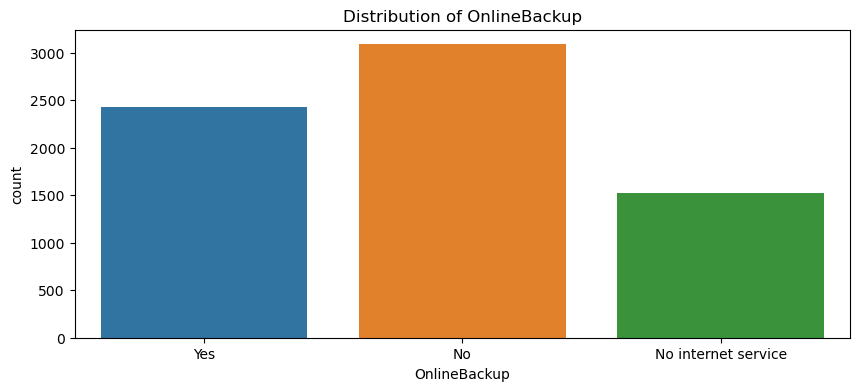

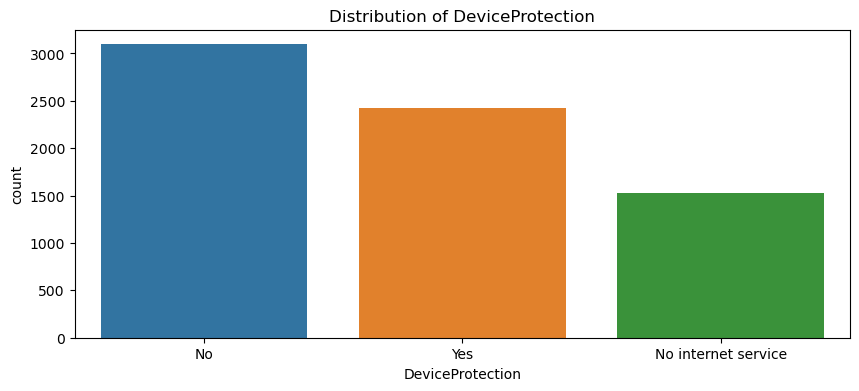

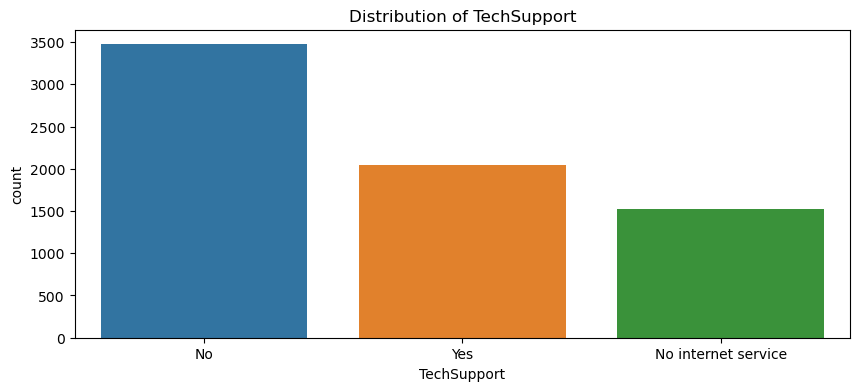

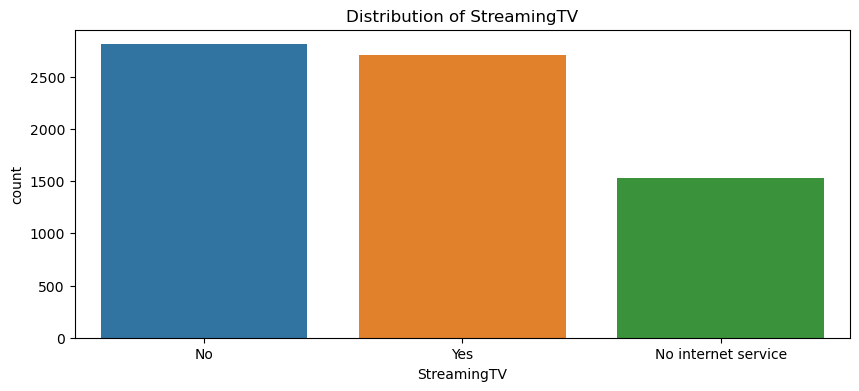

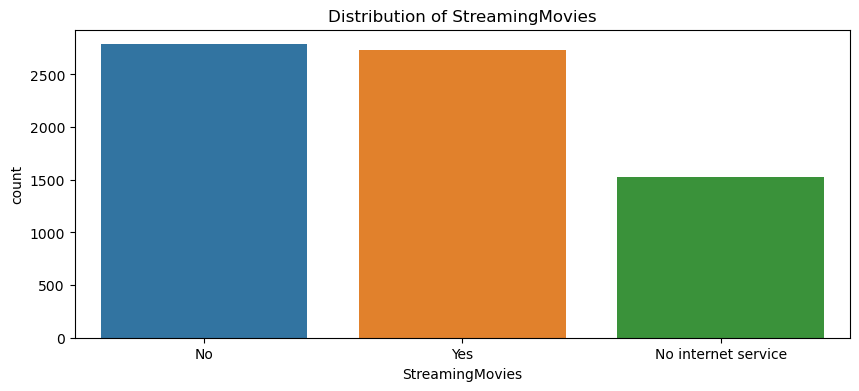

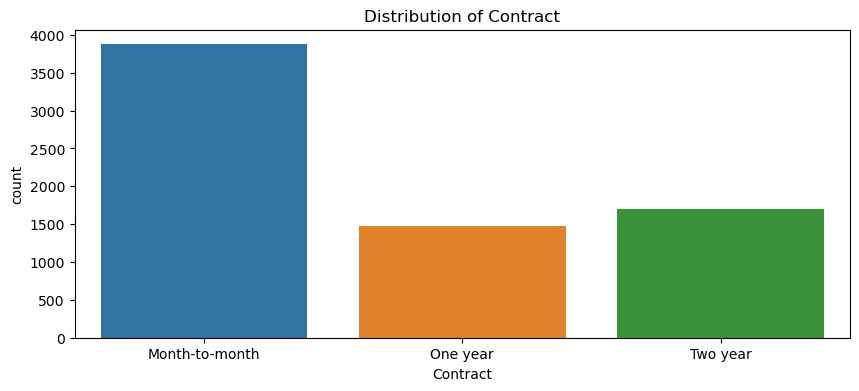

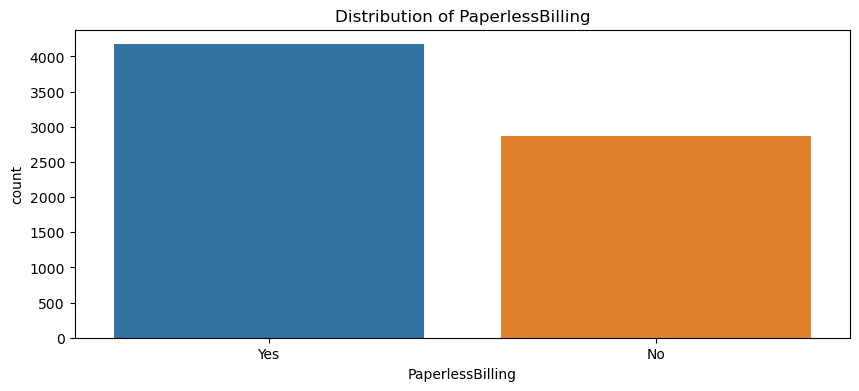

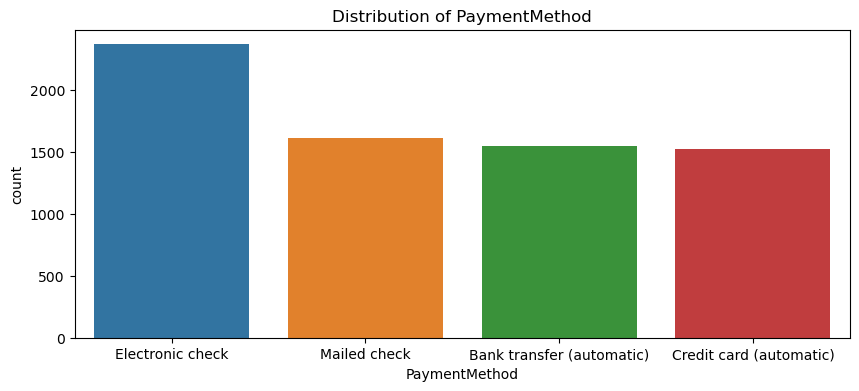

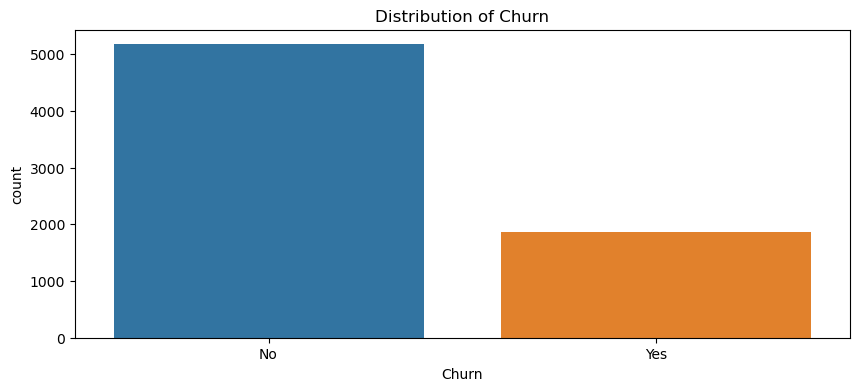

In [22]:
# Visualize Distributions of Categorical Variables

# To better understand the makeup of the customer base, we'll explore the 
# distribution of each categorical feature using count plots

cat_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

# Create a countplot for each categorical column
for col in cat_columns:
    plt.figure(figsize=(10,4))
    sns.countplot(x=col, data=data, )
    plt.title(f'Distribution of {col}')
    plt.show()

## Some insights :
# - Gender is almost evenly split between male and female
# - ~55 percent are month to month customers
# - ~90 percent have phone service
# - most customers (~84%) are not seniors
# - Approx %80 have some internet service




In [23]:
# After plotting the distributions, we now display the exact counts of each category
# in the categorical features. Helps us understand how balanced or imbalanced each feature is.
# Also useful for later steps like encoding (e.g., label encoding or one-hot encoding)

# Assign categorical features to cat_columns
cat_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

# Print the counts for each categorical column
for col in cat_columns:
    print(f'\nCounts for {col}:\n')
    print(data[col].value_counts())


Counts for gender:

gender
Male      3555
Female    3488
Name: count, dtype: int64

Counts for SeniorCitizen:

SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64

Counts for Partner:

Partner
No     3641
Yes    3402
Name: count, dtype: int64

Counts for Dependents:

Dependents
No     4933
Yes    2110
Name: count, dtype: int64

Counts for PhoneService:

PhoneService
Yes    6361
No      682
Name: count, dtype: int64

Counts for MultipleLines:

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Counts for InternetService:

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

Counts for OnlineSecurity:

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

Counts for OnlineBackup:

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dt

BIVARIATE ANALYSIS - Relationship between categorical variables and Churn

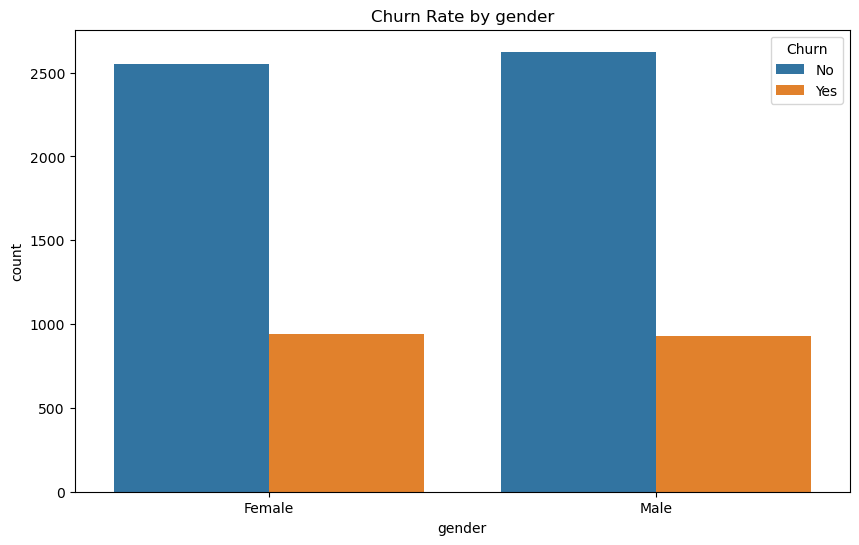

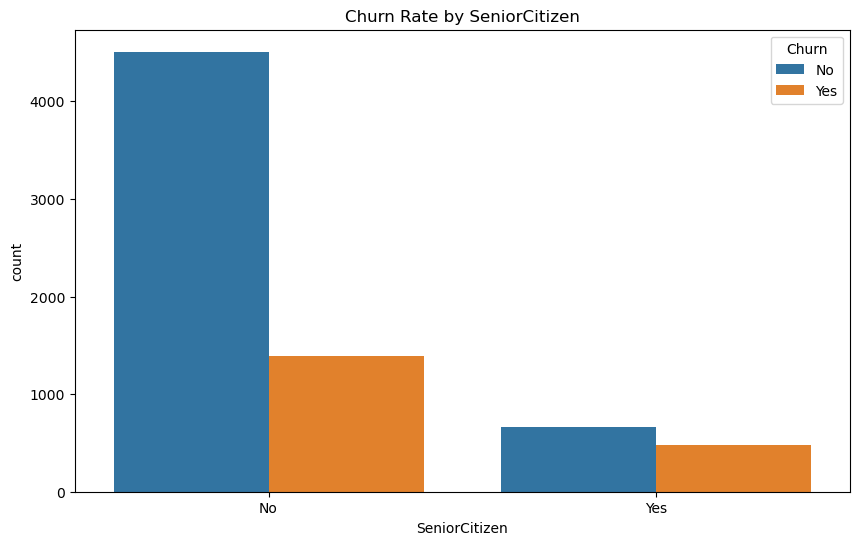

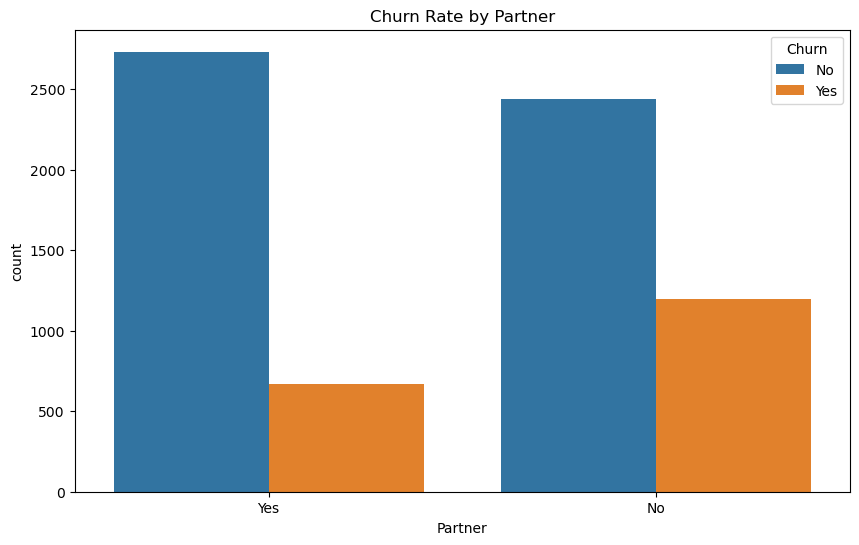

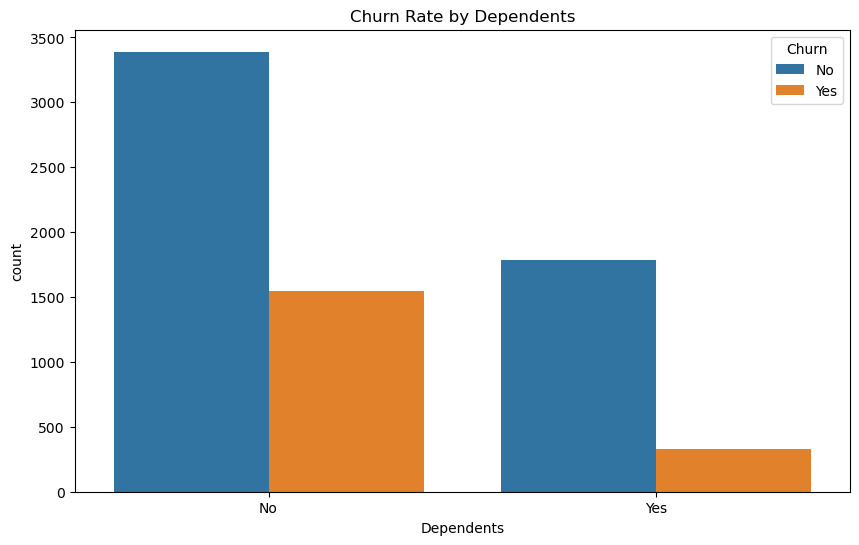

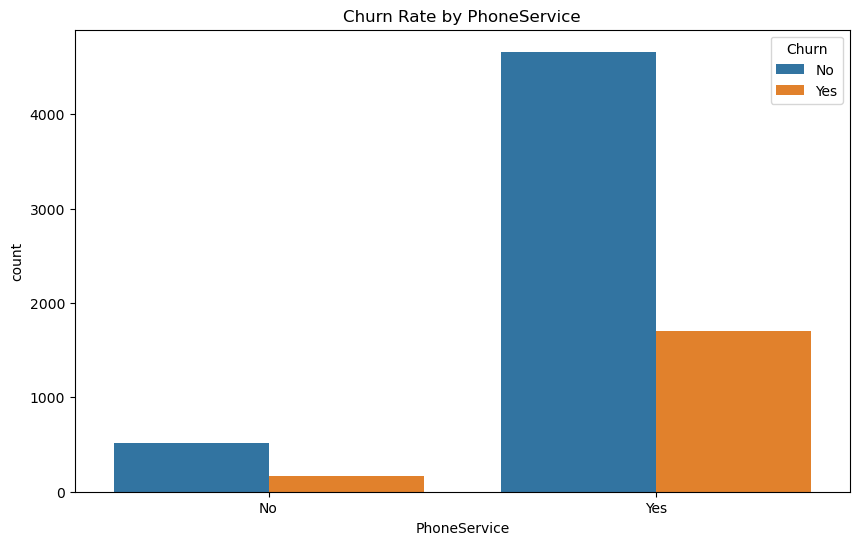

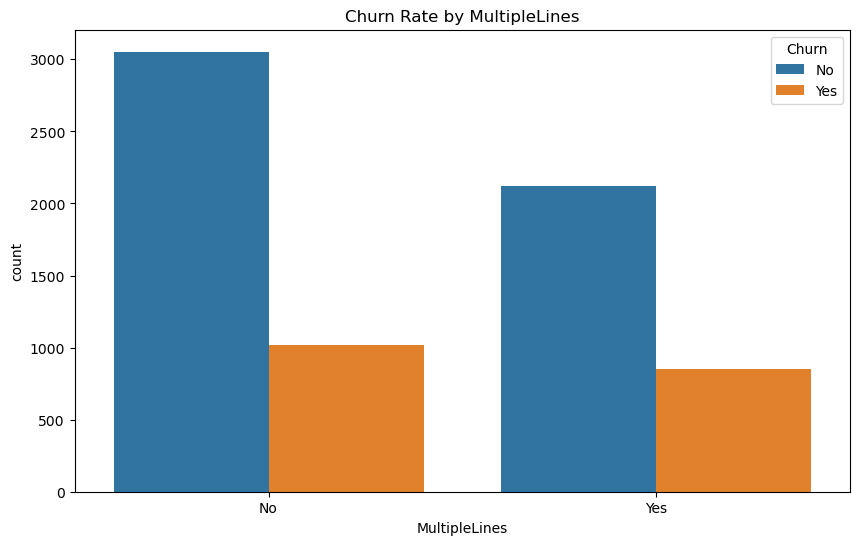

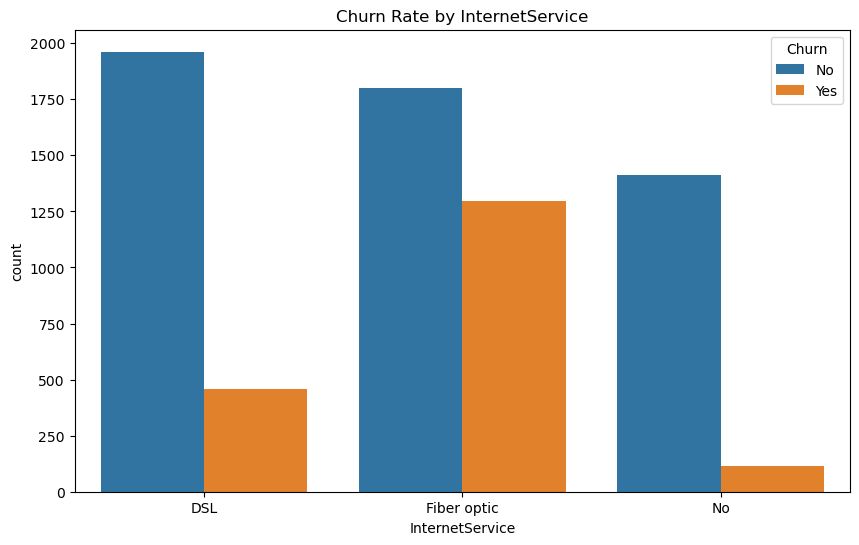

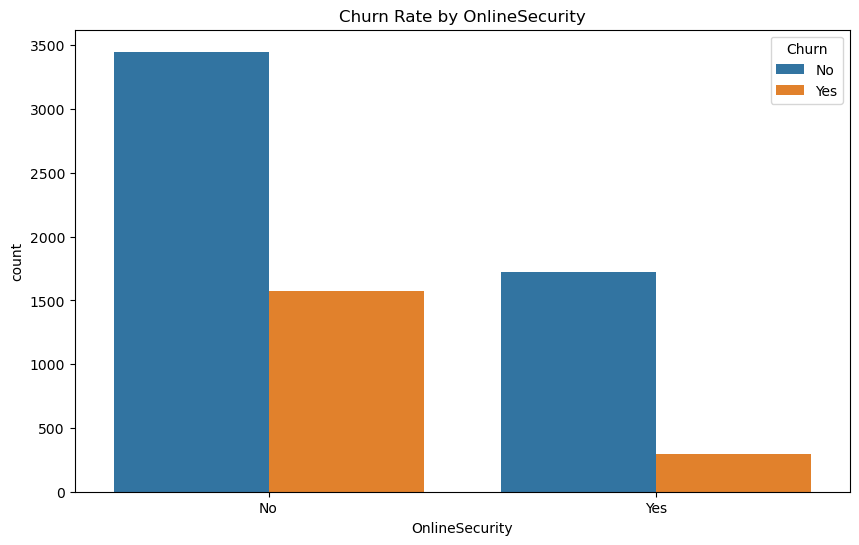

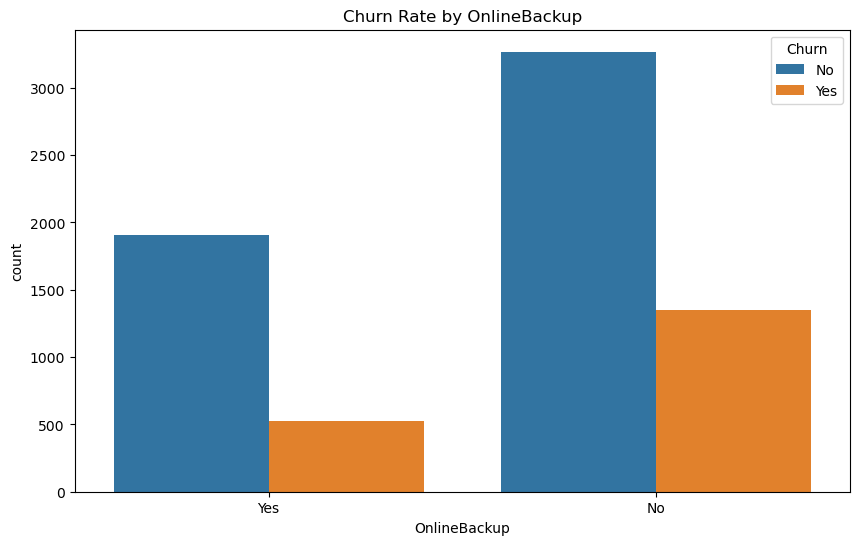

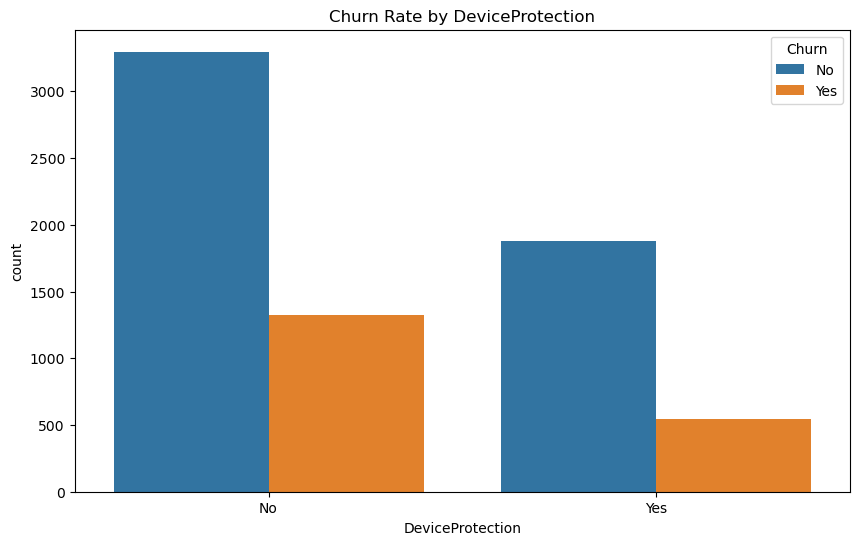

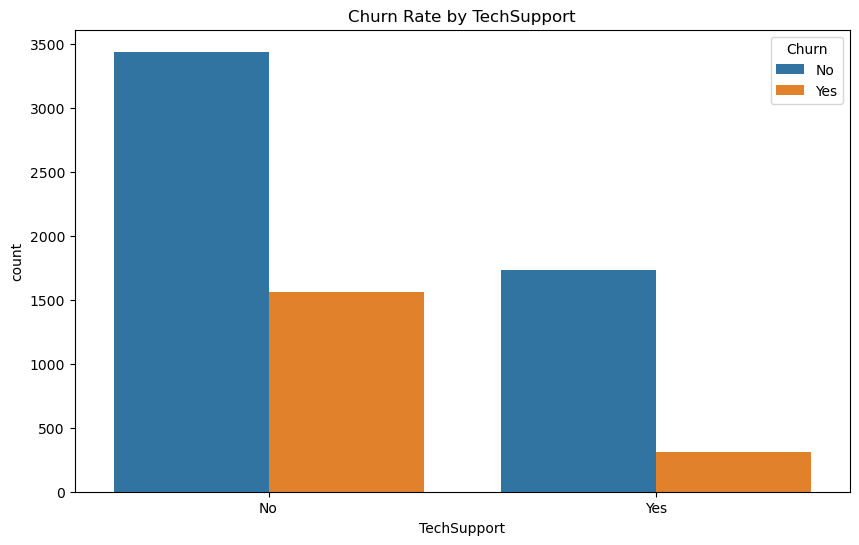

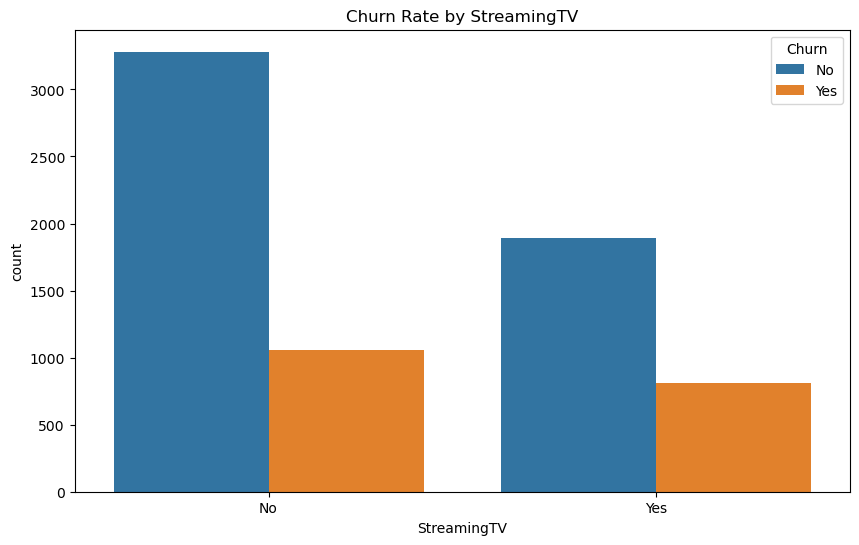

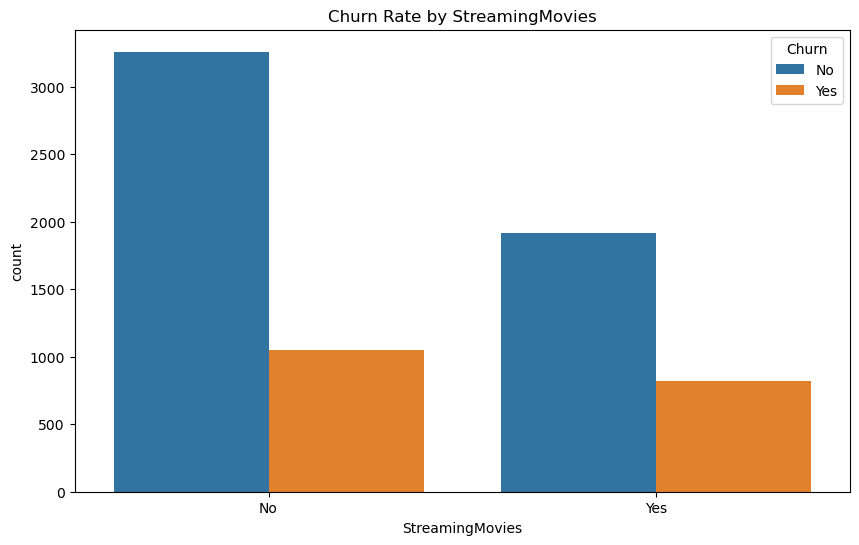

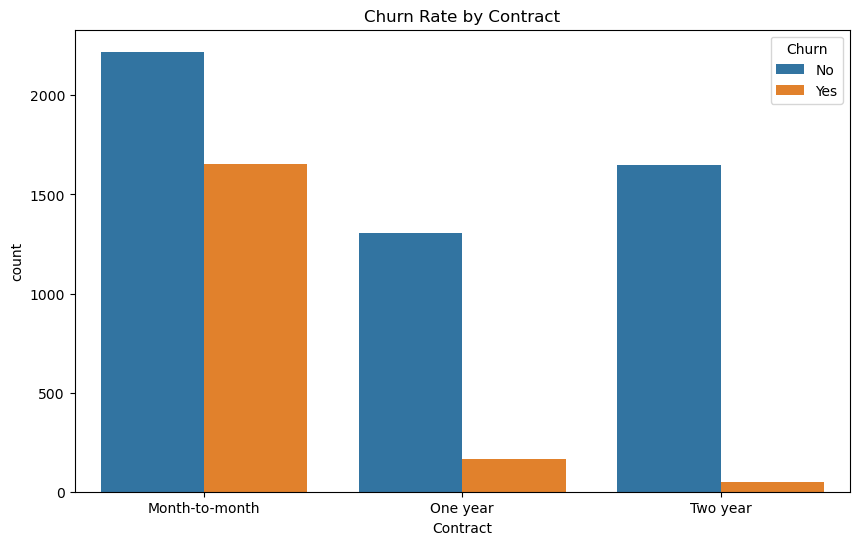

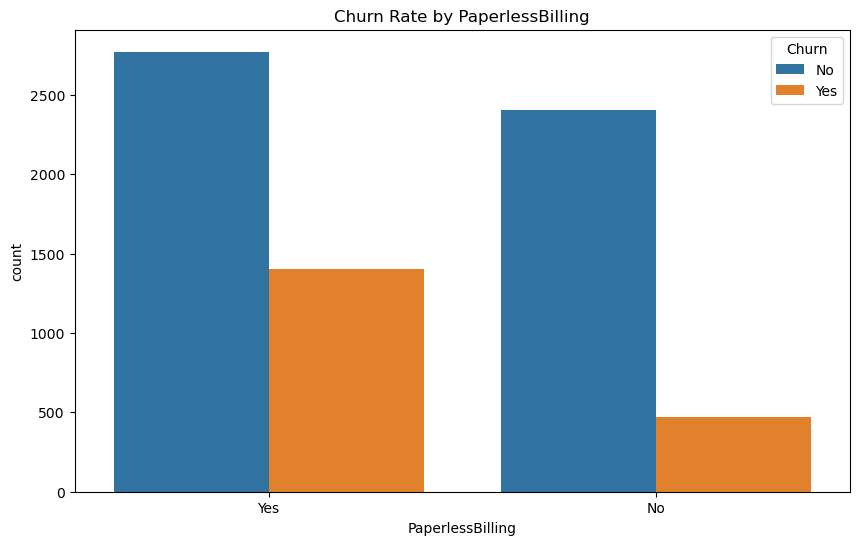

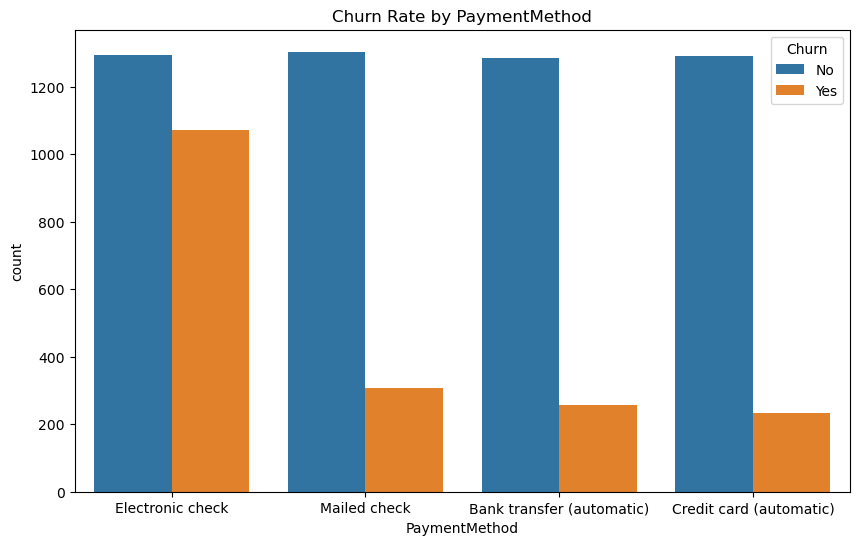

In [25]:
# Some columns had extra categories like 'No internet service' or 'No phone service' 
# These categories are effectively the same as 'No', so we can simplify them:

cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in cols:
     data[col] = data[col].replace('No internet service', 'No')

# do same for 'MultipleLines' feature

data['MultipleLines'] = data['MultipleLines'].replace('No phone service', 'No')



# Now let’s see how churn rates vary across each categorical feature.
# We'll use bar plots with color-coded churn levels:


# List of categorical columns (not including 'Churn')
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaperlessBilling', 'PaymentMethod']

#  bar plot for each categorical column
for col in cat_cols:
    plt.figure(figsize=(10,6))
    sns.countplot(x=col, hue='Churn',  data=data)
    plt.title(f'Churn Rate by {col}')
    plt.show()
    
# Obervations:  
# Feature categories that appear to have a positive association with churn:
# month-to-month contracts, seniors, paperless billing, paid with electronic check, fiber internet service

# Feature categories that appear to have a negative association with churn:
# 2 year contracts, having a partner/dependent




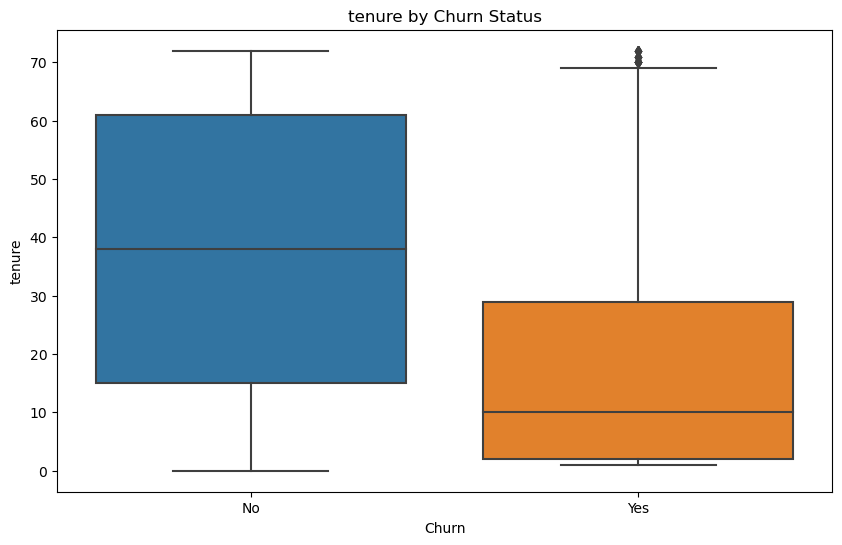

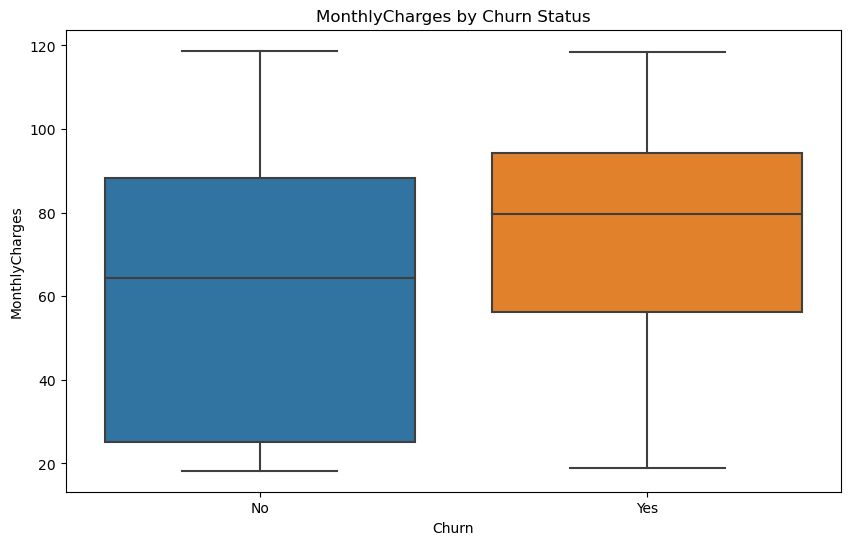

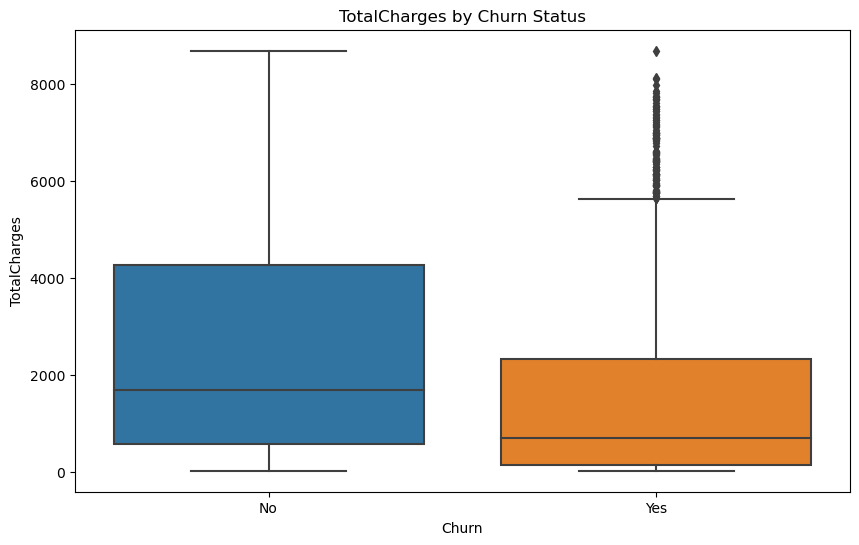

In [26]:
# Relationship Between Numerical Features and Churn

# Well now examine how numerical variables differ between customers who churned and those who did not. 
# We'll use boxplots to compare the distributions.


# numerical columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create boxplots for each numerical column
for col in num_cols:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='Churn', y=col, data=data)
    plt.title(f'{col} by Churn Status')
    plt.show()
    
# 1) short tenure customers have higher churn rate
# 2) median monthlycharge for churn:~ $80  NoChurn: ~$65
# 3) since short tenured have higher churn it makes sense
#    that they have lower 'totalcharges'


In [29]:
# Correlation of Churn (encoded as 0 or 1) with numeric variables

# Encode 'Churn' as a binary variable (if not already done)
data['Churn_binary'] = data['Churn'].map({'Yes': 1, 'No': 0})

# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Calculate correlations with Churn_binary
correlations = numeric_data.corr()['Churn_binary'].sort_values(ascending=False)

# Display correlations
print(correlations)

Churn_binary      1.000000
MonthlyCharges    0.193356
TotalCharges     -0.199484
tenure           -0.352229
Name: Churn_binary, dtype: float64


Label Encoder Transformation


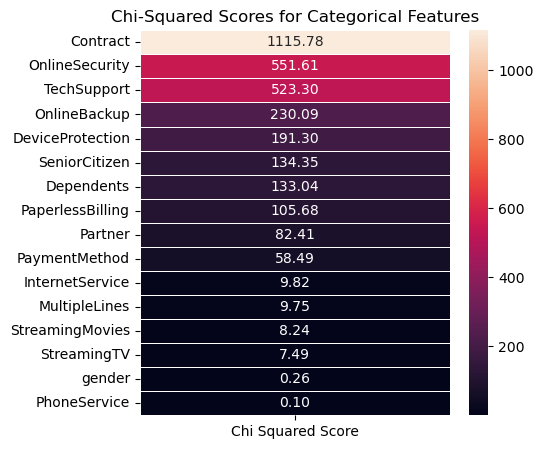

In [30]:
# Feature Selection Using Chi-Squared Test

# To help identify which categorical features are most strongly related to churn,
# we use a method called the Chi-Squared test. This statistical test checks whether
# there is a meaningful relationship between each feature and the churn outcome.

# Features with high chi-squared scores are likely to be more informative 
# for predicting churn, while features with low scores may be less important
# and can potentially be dropped from the dataset.

# This implementation uses Scikit-learn’s SelectKBest with the chi-squared scoring function 


# List of categorical features to test (excluding the target)
c_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                        'PaperlessBilling', 'PaymentMethod']


# Encode string categories as integers, since chi2 requires numerical input

le = LabelEncoder()

print('Label Encoder Transformation')
for i in c_features :
    df_temp[i] = le.fit_transform(df_temp[i])
    
# Ensure that the target variable has been converted to numeric
df_temp['Churn'] = le.fit_transform(df_temp['Churn'])

# Split features and target
features = df_temp.loc[:,c_features]
target = df_temp.loc[:,'Churn']

# Apply Chi-Squared feature selection
# This ranks features based on their relationship with churn
best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

# Store scores in a DataFrame for easy viewing
featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 


# Visualize the scores using a heatmap
plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,linewidths = 0.4,fmt = '.2f');
plt.title('Chi-Squared Scores for Categorical Features');